## Интеллектуальный анализ данных – весна 2025
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать с усеченным датасетом `Palmer Penguins`, содержащим информацию о характеристиках трех видов пингвинов: `Adelie`, `Chinstrap` и `Gentoo`:



*   Species — вид пингвина (целевая переменная).
*   Island — остров, на котором была сделана запись.
*   Clutch Completion — завершенность кладки яиц.
*   Date Egg — закодированная дата откладки яиц (число дней от самой ранней даты в данных).
*   Culmen Length (mm) — длина клюва.
*   Culmen Depth (mm) — глубина клюва.
*   Flipper Length (mm) — длина ласт.
*   Body Mass (g) — масса тела в граммах.
*   Sex — пол особи.
*   Delta 15 N (o/oo) и Delta 13 C (o/oo) — изотопные значения, характеризующие пищевые предпочтения.

Описание полного набора данных и дополнительную информацию о проекте можно найти [здесь](https://allisonhorst.github.io/palmerpenguins/index.html) и [здесь](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data?resource=download).

![Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)



In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [133]:
data = pd.read_csv('penguins_data.csv')
data.head(5)

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Chinstrap,Dream,Yes,382,50.9,19.1,196.0,3550.0,MALE,10.02372,-24.86594
1,Chinstrap,Dream,Yes,741,45.2,17.8,198.0,3950.0,FEMALE,8.88942,-24.49433
2,Gentoo,Biscoe,Yes,744,46.5,13.5,210.0,4550.0,FEMALE,7.99530,-25.32829
3,Chinstrap,Dream,Yes,10,45.2,16.6,191.0,3250.0,FEMALE,9.62357,-24.78984
4,Gentoo,Biscoe,Yes,13,48.4,14.4,203.0,4625.0,FEMALE,8.16582,-26.13971


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные признаки? Если да, то закодируйте их самым оптимальным способом. Аргументируйте свой выбор.

In [134]:
data_empty = data.isna().sum().sum()
print(f"Sum of empty values: {data_empty}")

Sum of empty values: 45


В наборе есть 45 пустых значений, поэтому удалим их.

In [135]:
data = data.dropna()
data_empty = data.isna().sum().sum()
print(f"Sun of empty values: {data_empty}")

Sun of empty values: 0


In [136]:
data.select_dtypes(include=object).head(5)

,Species,Island,Clutch Completion,Sex
0,Chinstrap,Dream,Yes,MALE
1,Chinstrap,Dream,Yes,FEMALE
2,Gentoo,Biscoe,Yes,FEMALE
3,Chinstrap,Dream,Yes,FEMALE
4,Gentoo,Biscoe,Yes,FEMALE


Да, в наборе есть категориальные признаки `Species`, `Island`, `Clutch Completion`, `Sex`.

Целевую категориальную переменную закодируем в ординальном порядке: Chinstrap = 0, Gentoo = 1, Adelie = 2. Воспользуемся [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

Сохраним информацию о признаках в переменную `X`, а о целевой переменной – в переменную `y`.

In [137]:
df = pd.DataFrame(data)
encoder = OrdinalEncoder(categories=[['Chinstrap', 'Gentoo', 'Adelie']])
df['Species_Encoded'] = encoder.fit_transform(df[['Species']])

X = df.drop(columns=['Species_Encoded', 'Species'], axis=1)

y = df['Species_Encoded']
print(y.value_counts())

Species_Encoded
2.0    139
1.0    119
0.0     67
Name: count, dtype: int64


Закодируем категориальные признаки, используя one-hot кодирование.

Выбран one-hot, потому что дальше будем использовать метод kNN, в котором вычисляется расстояние до объектов, и поэтому важно правильно интерпретировать расстояние по категориальным признакам, что one-hot делает оптимальнее, чем, например, OrdinalEncoder. К тому же в данном наборе признаки `Clutch Completion` и `Sex` имеют по 2 значения, и их можно удобно бинарно закодировать.

In [138]:
X = pd.get_dummies(X, drop_first=True)
X.head(5)

,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Dream,Island_Torgersen,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,382,50.9,19.1,196.0,3550.0,10.02372,-24.86594,True,False,True,False,True
1,741,45.2,17.8,198.0,3950.0,8.88942,-24.49433,True,False,True,True,False
2,744,46.5,13.5,210.0,4550.0,7.99530,-25.32829,False,False,True,True,False
3,10,45.2,16.6,191.0,3250.0,9.62357,-24.78984,True,False,True,True,False
4,13,48.4,14.4,203.0,4625.0,8.16582,-26.13971,False,False,True,True,False


**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [139]:
np.random.seed(8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8, stratify=y)

Важно использовать `stratify`, чтобы в тренировочных и тестовых наборах пропорции классов были одинаковыми, чтобы данные были сбалансированы, модель лучше обучилась и выбросы не так сильно влияли на обучение и результат. 

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака:  `Flipper Length (mm)` и `Body Mass (g)`  – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [140]:
scaler = StandardScaler()
X_train_scale = pd.DataFrame(data=scaler.fit_transform(X_train[['Flipper Length (mm)', 'Body Mass (g)']]))
X_test_scale = pd.DataFrame(data=scaler.fit_transform(X_test[['Flipper Length (mm)', 'Body Mass (g)']]))

neighbours_count = [1, 3, 5, 10, 15, 25]
clfs = []

print("NN\tTrain\tTest")
for i in neighbours_count:
    clf = KNeighborsClassifier(n_neighbors=i, p=2)
    clf.fit(X_train_scale, y_train)

    y_train_predicted = clf.predict(X_train_scale)
    y_test_predicted = clf.predict(X_test_scale)

    accuracy_train = accuracy_score(y_train, y_train_predicted)
    accuracy_test = accuracy_score(y_test, y_test_predicted)

    clfs.append(clf)
    print(f"{i}\t{accuracy_train:.2f}\t{accuracy_test:.2f}")

NN	Train	Test
1	0.96	0.76
3	0.87	0.82
5	0.84	0.80
10	0.82	0.83
15	0.81	0.81
25	0.79	0.83


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [ ]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [141]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

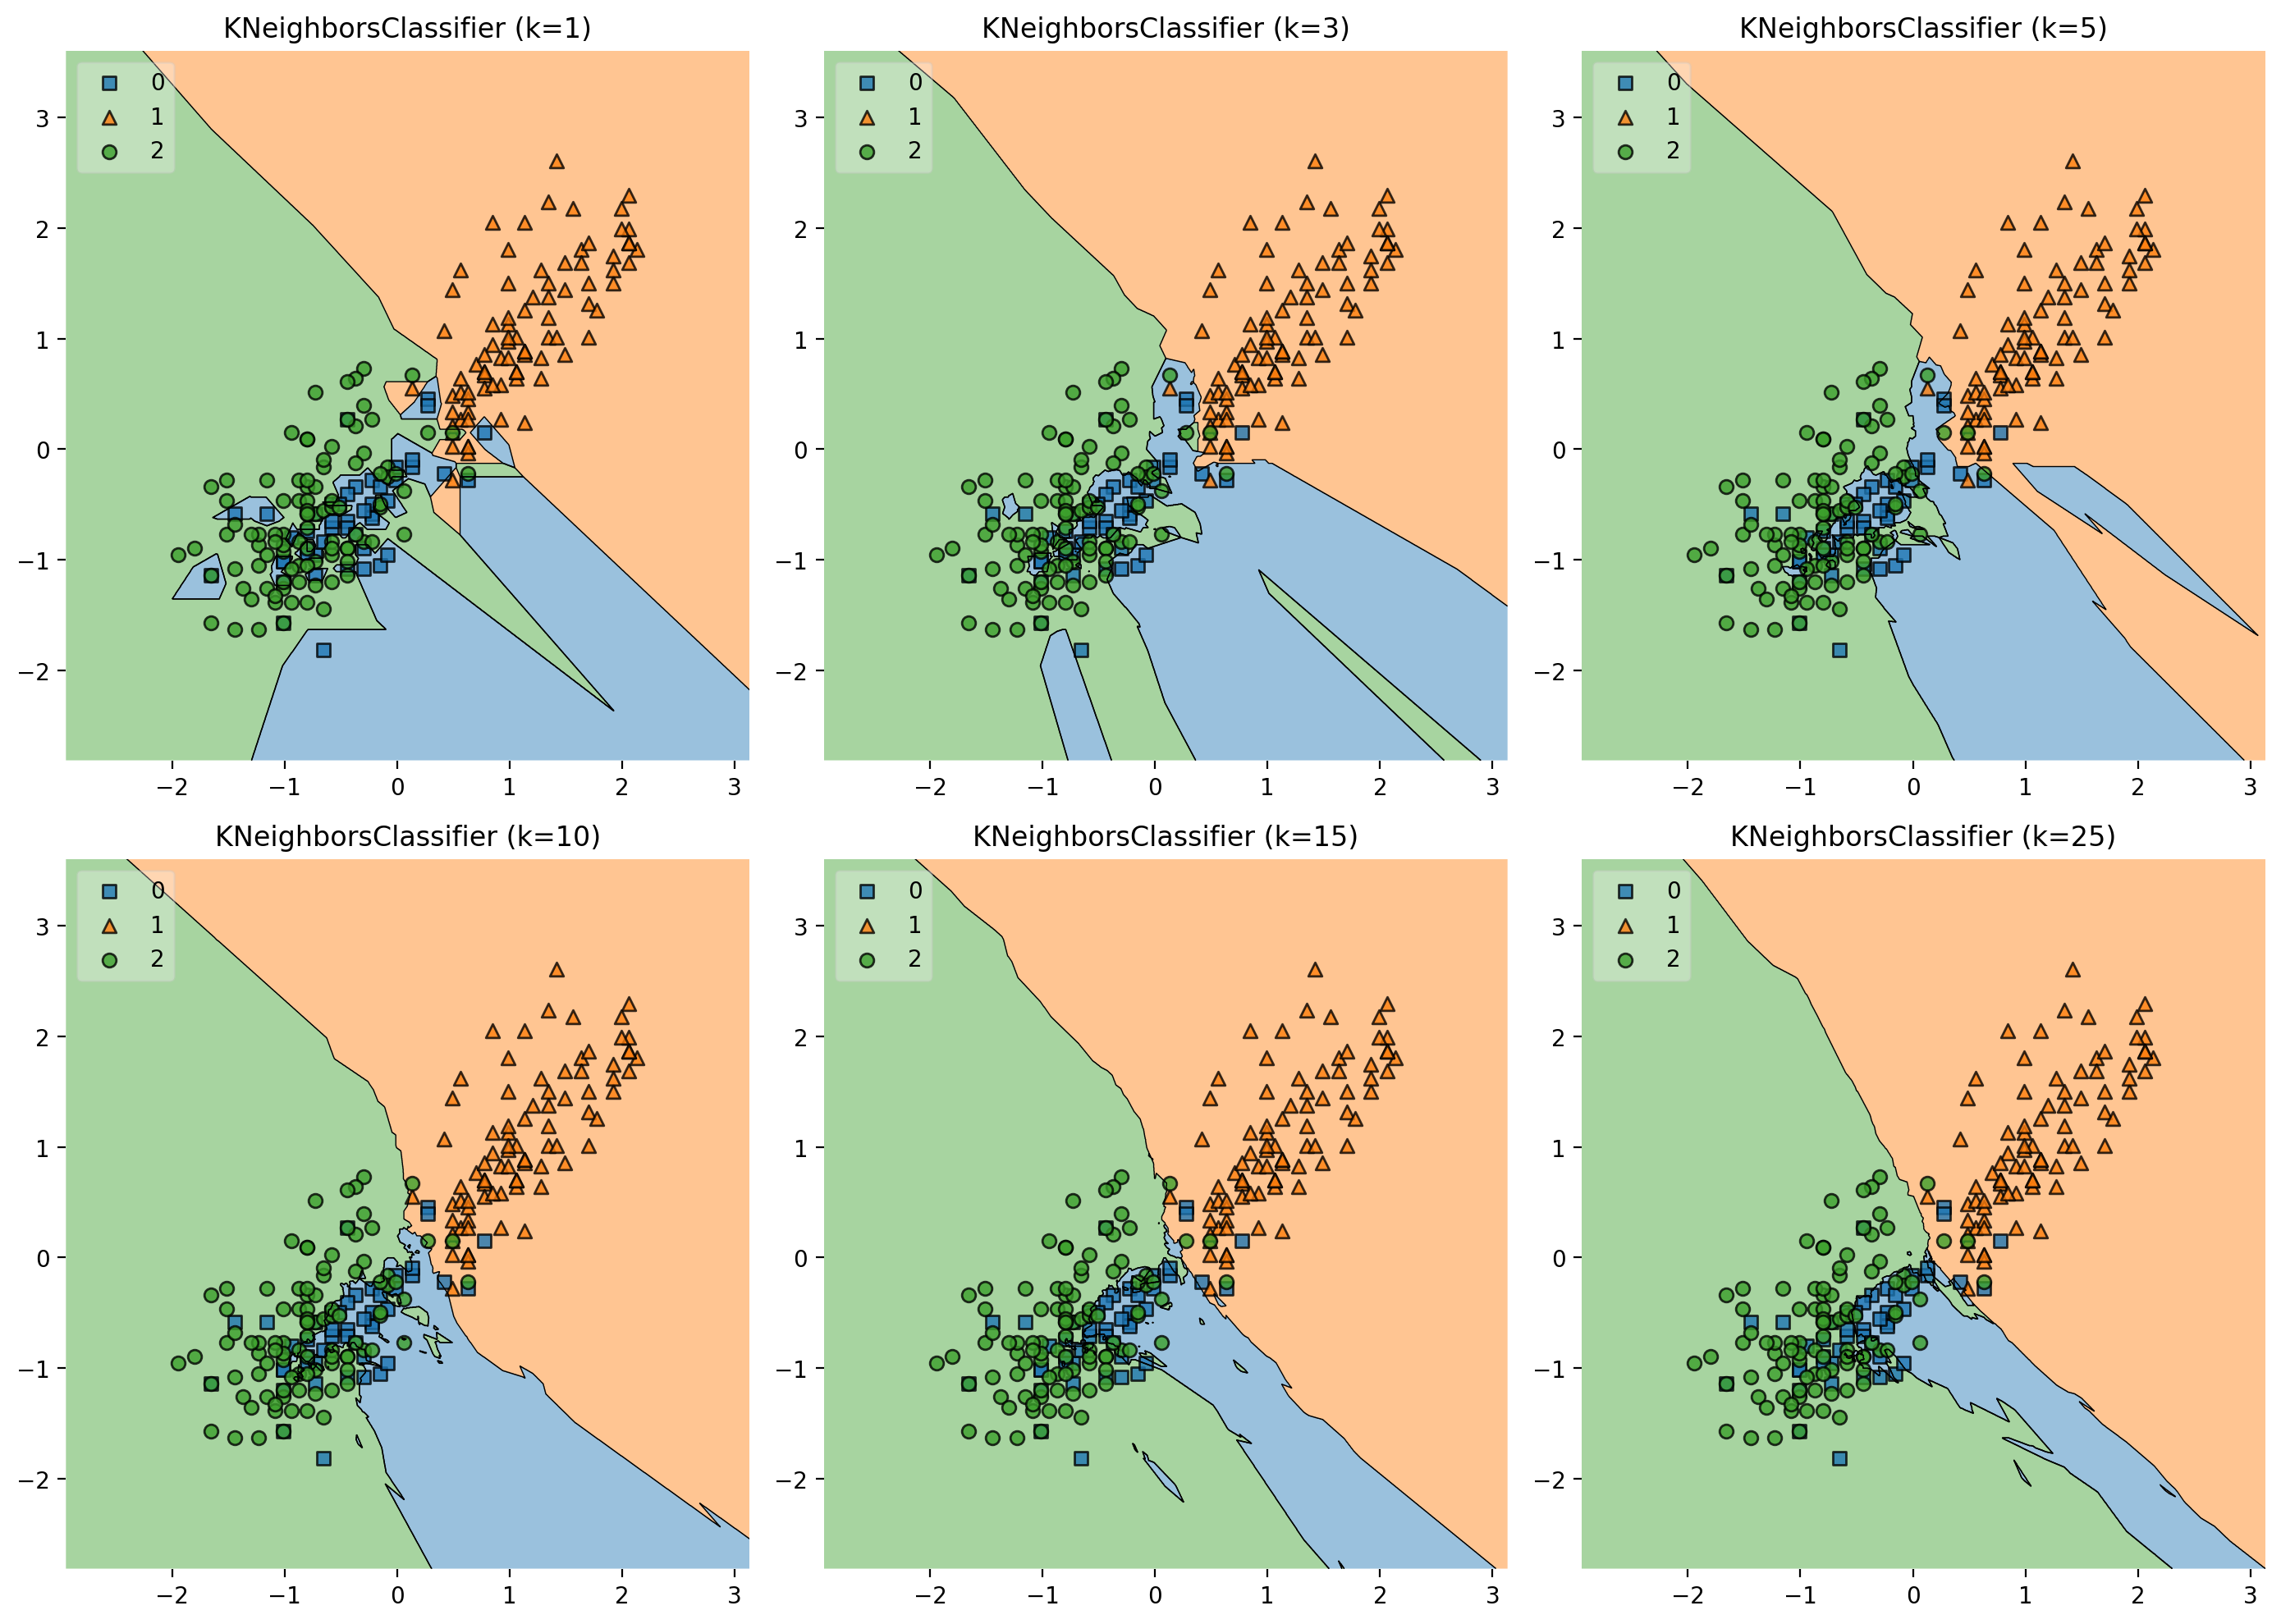

In [16]:
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(14, 10), dpi=200)

for clf, neighbours, grd in zip(clfs, neighbours_count, itertools.product(range(3), repeat=2)):
    ax = plt.subplot(gs[grd])
    fig = plot_decision_regions(np.array(X_train_scale), np.array(y_train).astype(int), clf=clf, legend=2)
    plt.title(f"KNeighborsClassifier (k={neighbours})")

plt.tight_layout()
plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

В задаче 1.3 получили следующий результат:
```
NN	Train	Test
1	0.96	0.76
3	0.87	0.82
5	0.84	0.80
10	0.82	0.83
15	0.81	0.81
25	0.79	0.83
```
По этой таблице можно сделать вывод, что наиболее точные предсказания происходят при 10 и 25 соседях в методе kNN.

При `k = 1` модель сильно переобучается, потому что на тренировочной выборке хороший результат, а на тестовой - сильно хуже. Также есть переобучение при `k = 3` и `k = 5`. Это же видно и по их графикам - при `k = 1`, `k = 3`, `k = 5` сильно выделяются "островки", выбросы, которые могут мешать на реальных данных, это свидетельствует о том, что модель подогналась под выборку.

При `k = 10` график имеет более плавные переходы и без сильных выбросов. Также по таблице видно, что модель хорошо обучилась и выдаёт хорошие результаты на тесте.

В двух остальных случаях, судя по графикам, количество соседей слишком много, поэтому появилось больше неточностей по сравнению с предыдущими моделями. Например, в центре в окрестностях точки (0, 0) и синяя область (особенно при `k = 25` по сравнению с `k = 10`). Но при этом, судя по таблице, результаты довольно неплохие.

Отсюда делаем вывод, что **оптимальное число соседей - 10**.

### Задание 2. KNN своими руками. 2,5 балла

**Задача 2.1 (2 балла)** В данном задании мы попробуем реализовать алгоритм KNN своими руками, делать мы будем KNN именно для классификации.

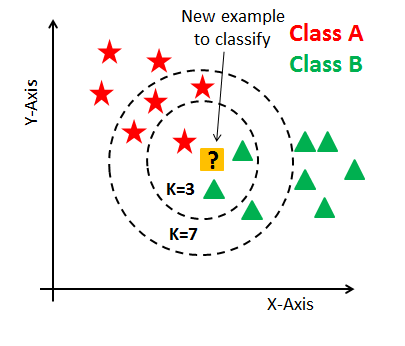

Рекомендации по реализации:
- Используйте `numpy` для представления данных в виде массивов, чтобы минимизировать преобразования.
- Избегайте циклов по всем объектам, по возможности используйте векторизированные операции.
- Обратите внимание на методы [np.linalg.norm()](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) и [np.argsort()](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html), а также на класс `collections.Counter`.
- Особый плюс, если учтёте обработку возможных ошибок.

In [142]:
import numpy as np
from collections import Counter

class KNN:
  def __init__(self, k:int):
    if k <= 0:
      raise ValueError("k must be positive.")
    self.k = k

  def fit(self, X, y):
    if self.k > X.shape[0]:
      raise ValueError("k is too large for dataset.")
    if X.shape[0] != y.shape[0]:
      raise ValueError("X and y must be the same size")
    
    self.X_train = X
    self.y_train = y
    return self

  def predict(self, X):
    y = []
    for x in X:
      distances = [self.count_distance(x_train, x) for x_train in self.X_train]

      neighbours_indices = np.argsort(distances)[:self.k]
      neighbours = self.y_train[neighbours_indices]

      prediction = Counter(neighbours).most_common()[0][0]
      y.append(prediction)
    return np.array(y)

  def count_distance(self, x, y):
    try:
      return np.linalg.norm(x - y)
    except:
      raise ValueError("Error in distance")

In [143]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [102]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

**Задача 2.2 (0.5 балла)** Протестируйте ваш алгоритм на данных о пингвинах. Выведите лучший получившийся результат на тестовой выборке.

In [144]:
best_k = 0
best_accuracy = 0
print("K\tAccuracy")
for k in neighbours_count:
    knn = KNN(k=k)
    knn.fit(X_train.values, y_train.values)
    accuracy = accuracy_score(y_test.values, knn.predict(X_test.values))
    print(f"{k}\t{accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"Лучшее k: {best_k} с точностью {best_accuracy:.4f} на test.")

K	Accuracy
1	0.7551
3	0.7857
5	0.7551
10	0.7755
15	0.7551
25	0.7245
Лучшее k: 3 с точностью 0.7857 на test.


### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [179]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [180]:
data.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

Пропущенных значений нет.

Бессмысленный столбец `Unnamed: 0`, потому что это просто порядковый номер объекта. Удалим его.

In [181]:
data = data.drop('Unnamed: 0', axis=1)
data.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Задача 3.2 (0.2 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Постройте матрицу корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки имеют наибольшую корреляцию с целевой переменной?

In [182]:
numerics = ['carat', 'depth', 'table', 'x', 'y', 'z']
data[numerics + ['price']].corr(method='pearson')

,carat,depth,table,x,y,z,price
carat,1.000000,0.028224,0.181618,0.975094,0.951722,0.953387,0.921591
depth,0.028224,1.000000,-0.295779,-0.025289,-0.029341,0.094924,-0.010647
table,0.181618,-0.295779,1.000000,0.195344,0.183760,0.150929,0.127134
x,0.975094,-0.025289,0.195344,1.000000,0.974701,0.970772,0.884435
y,0.951722,-0.029341,0.183760,0.974701,1.000000,0.952006,0.865421
z,0.953387,0.094924,0.150929,0.970772,0.952006,1.000000,0.861249
price,0.921591,-0.010647,0.127134,0.884435,0.865421,0.861249,1.000000


Нарисуем красивый график корреляций

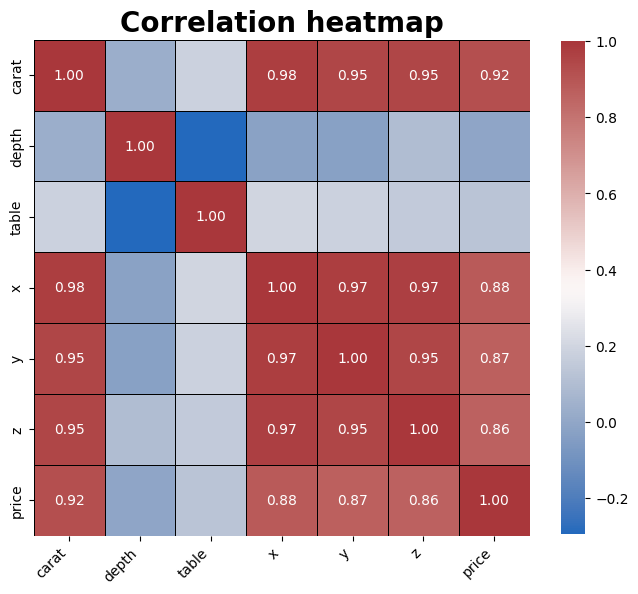

In [183]:
import seaborn as sns

plt.figure(figsize=(8, 8), dpi=100)

ax = sns.heatmap(
    data[numerics + ['price']].corr(numeric_only=True),
    cmap='vlag',
    annot=True,
    fmt='0.2f',
    linewidths=0.5,
    linecolor='black',
    cbar_kws={'shrink': 0.8},
    square=True
)

for t in ax.texts:
    if np.abs(float(t.get_text())) < 0.5:
        t.set_text("")

plt.title('Correlation heatmap', fontsize=20, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.show()

Наибольшую корреляцию с целевой переменной `price` имеет признак `carat`. Также имеют хорошую корреляцию признаки `x`, `y`, `z`.

**Задача 3.3 (0.2 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные признаки методом OneHot-кодирования (`pd.get_dummies()` или `OneHotEncoder` из `sklearn`).

In [184]:
data = pd.get_dummies(data, drop_first=True)
data.head(5)

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,326,3.89,3.84,2.31,False,False,True,...,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,327,4.05,4.07,2.31,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,4.20,4.23,2.63,False,False,True,...,False,True,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,True,False,False,...,False,False,True,False,False,True,False,False,False,False


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

Сначала найдём оптимальный параметр `stratify`, чтобы равномерно распределить целевую переменую. 

Для этого разделим `price` на интервалы, используя формулу Стёрджеса: $k = 1 + \lfloor \log_2{n} \rfloor$.

In [185]:
k = 1 + int(np.log2(len(data)))

Посмотрим на распределение цен.

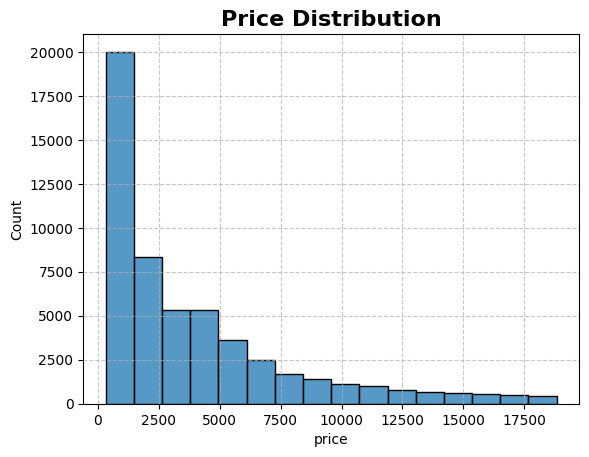

In [186]:
sns.histplot(data['price'], bins=k)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Price Distribution', fontsize=16, fontweight='bold')
plt.show()

Для разделения будем использовать [KBinsDiscretizer](https://scikit-learn.ru/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html) из `sklearn`. 

Так как распределение неравномерно, устанавливаем параметр `strategy` равным `quantile`, чтобы распределить данные по интервалам равномерно.  

In [187]:
from sklearn.preprocessing import KBinsDiscretizer

data['price_stratify'] = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='quantile').fit_transform(data[['price']])[:, 0]

Посмотрим на полученные данные:

In [188]:
data['price_stratify'].value_counts()

price_stratify
3.0     3410
5.0     3383
8.0     3377
10.0    3374
11.0    3373
15.0    3373
6.0     3373
9.0     3372
13.0    3371
14.0    3371
12.0    3370
0.0     3364
1.0     3364
4.0     3360
7.0     3360
2.0     3345
Name: count, dtype: int64

Теперь разделим данные на тренировочные и тестовые.

In [189]:
X = data.drop(columns=['price', 'price_stratify'], axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8, stratify=data['price_stratify'])

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче стандартизируйте вещественные признаки в тренировочной и тестовой выборках с помощью `StandardScaler`.

Объясните, как это повлияет на интерпретацию коэффициентов линейной регрессии.

In [190]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Масштабирование значительно повлияет на интерпретацию коэффициентов, потому что они станут более объективно отображать важность признаков. До масштабирования коэффициенты при признаках с высокими значениями могут иметь более высокий вес, хотя это не означает, что эти признаки реально имеют высокую важность для предсказания результата. После масштабирования все признаки имеют одинаковый масштаб, что решает эту проблему. Также это влияет на штрафы больших весов при регуляризации.

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [191]:
from sklearn.linear_model import LinearRegression

def MSE(y: np.array, y_pred: np.array):
    return ((y - y_pred) ** 2).mean()

def print_MSE(X: np.array, y: np.array, name: str):
    print(f"MSE for {name}: {MSE(y, linear_model.predict(X)):.2f}")

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
print_MSE(X_train, y_train, 'train')
print_MSE(X_test, y_test, 'test')

MSE for train: 1244764.00
MSE for test: 1355052.73


**Задача 3.7 (0.3 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [192]:
df_features = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linear_model.coef_,
    'Coefficient (abs)': np.abs(linear_model.coef_)
})
df_features.sort_values(by='Coefficient (abs)', inplace=True, ascending=False)
df_features


,Feature,Coefficient,Coefficient (abs)
0,carat,5396.800747,5396.800747
20,clarity_VS2,1778.920212,1778.920212
19,clarity_VS1,1638.831075,1638.831075
17,clarity_SI1,1571.162114,1571.162114
22,clarity_VVS2,1451.512333,1451.512333
21,clarity_VVS1,1254.485761,1254.485761
3,x,-1184.042172,1184.042172
18,clarity_SI2,1004.933148,1004.933148
16,clarity_IF,959.992146,959.992146
15,color_J,-524.826301,524.826301


Среди всех признаков выделяются коэффициенты `carat`, а также признаки связанные с `clarity`.

Посмотрим только на вещественные переменные.

In [193]:
df_features_numerics = df_features[df_features['Feature'].isin(numerics)]
df_features_numerics

,Feature,Coefficient,Coefficient (abs)
0,carat,5396.800747,5396.800747
3,x,-1184.042172,1184.042172
1,depth,-87.288867,87.288867
2,table,-59.672264,59.672264
5,z,-21.580408,21.580408
4,y,-7.807362,7.807362


Выделяются признаки `carat` и `x`, потому что их коэффициенты по модулю значительно превышают остальные коэффициаенты. 

**Задача 3.8 (0.5 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, установив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [194]:
from sklearn.linear_model import Lasso, Ridge

alpha = 10
lasso = Lasso(alpha).fit(X_train, y_train)
ridge = Ridge(alpha).fit(X_train, y_train)

print(f"Lasso: {MSE(y_test, lasso.predict(X_test)):.2f}")
print(f"Ridge: {MSE(y_test, ridge.predict(X_test)):.2f}\n")

Lasso: 1409046.66
Ridge: 1354458.12



In [195]:
def print_coefficient(model):
    df_features = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_,
        'Coefficient (abs)': np.abs(model.coef_)
    })
    df_features.sort_values(by='Coefficient (abs)', inplace=True, ascending=False)
    return df_features

In [197]:
print('Coefficients for Ridge:')
print_coefficient(ridge)

Coefficients for Ridge:


,Feature,Coefficient,Coefficient (abs)
0,carat,5355.172224,5355.172224
20,clarity_VS2,1749.913081,1749.913081
19,clarity_VS1,1613.741135,1613.741135
17,clarity_SI1,1541.129554,1541.129554
22,clarity_VVS2,1431.334344,1431.334344
21,clarity_VVS1,1237.408198,1237.408198
3,x,-1137.784199,1137.784199
18,clarity_SI2,979.494236,979.494236
16,clarity_IF,947.719172,947.719172
15,color_J,-523.445878,523.445878


In [198]:
print('Coefficients for Lasso:')
print_coefficient(lasso)

Coefficients for Lasso:


,Feature,Coefficient,Coefficient (abs)
0,carat,4874.780444,4874.780444
20,clarity_VS2,1071.538284,1071.538284
19,clarity_VS1,1022.963459,1022.963459
22,clarity_VVS2,950.233982,950.233982
17,clarity_SI1,843.893688,843.893688
21,clarity_VVS1,824.543686,824.543686
3,x,-713.793366,713.793366
16,clarity_IF,646.807842,646.807842
15,color_J,-465.423853,465.423853
18,clarity_SI2,376.760058,376.760058


Сравнение:


In [199]:
df_features = pd.DataFrame({
    'Feature': X.columns,
    'Linreg': np.abs(linear_model.coef_),
    'Ridge': np.abs(ridge.coef_),
    'Lasso': np.abs(lasso.coef_),
})
df_features.sort_values(by='Linreg', inplace=True, ascending=False)
df_features

,Feature,Linreg,Ridge,Lasso
0,carat,5396.800747,5355.172224,4874.780444
20,clarity_VS2,1778.920212,1749.913081,1071.538284
19,clarity_VS1,1638.831075,1613.741135,1022.963459
17,clarity_SI1,1571.162114,1541.129554,843.893688
22,clarity_VVS2,1451.512333,1431.334344,950.233982
21,clarity_VVS1,1254.485761,1237.408198,824.543686
3,x,1184.042172,1137.784199,713.793366
18,clarity_SI2,1004.933148,979.494236,376.760058
16,clarity_IF,959.992146,947.719172,646.807842
15,color_J,524.826301,523.445878,465.423853


В `Ridge` коэффициенты почти не не уменьшились и остались примерно на том же уровне, что и в обычной линейной регрессии.\
`Lasso` заметно снизил коэффициенты, а некоторые ещё и занулил.

Судя по `Lasso`, можно сказать, что в изначальной регрессии был ненужный признак `y`, так как он имел слабую корреляцию с целевой переменной. Но в целом все признаки имеют какой-то смысл.

`Ridge` сохранил все признаки, но 11 признаков с наибольшими коэффициентами в линейной регрессии значительно уменьшил, что может сказать о сильной мультиколлинеарности этих признаков.


**Задача 3.9 (0.5 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод сильнее снижает норму коэффициентов? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

In [200]:
alphas = [0.1, 1, 10, 100, 200]

lasso_coef_norms = []
ridge_coef_norms = []

for alpha in alphas:
    lasso = Lasso(alpha).fit(X_train, y_train)
    ridge = Ridge(alpha).fit(X_train, y_train)

    lasso_coef_norms.append(np.linalg.norm(lasso.coef_))
    ridge_coef_norms.append(np.linalg.norm(ridge.coef_))

df_alpha_norm = pd.DataFrame({
    'alpha': alphas,
    'Lasso': lasso_coef_norms,
    'Ridge': ridge_coef_norms
})

df_alpha_norm

,alpha,Lasso,Ridge
0,0.1,6731.671890,6744.790167
1,1.0,6607.844794,6737.928718
2,10.0,5464.908662,6670.499743
3,100.0,3871.738726,6095.957406
4,200.0,3584.294332,5612.407769


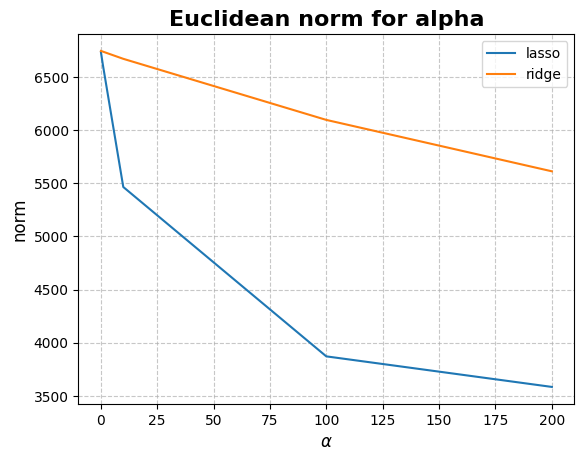

In [201]:
fig = plt.figure(dpi=100)
plt.plot(alphas, lasso_coef_norms, label='lasso')
plt.plot(alphas, ridge_coef_norms, label='ridge')
plt.xlabel(r'$\alpha$', fontsize=12)
plt.ylabel('norm', fontsize=12)
plt.legend()
plt.title("Euclidean norm for alpha", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

`Lasso` сильнее снижает норму коэффициентов. 

`Lasso` используют для отбора признаков, потому что она зануляет признаки, которые слабо коррелируют с целевой переменно, поэтому они не играют важной роли в предсказании, а также она зануляет признаки, которые сильно коррелируют с другими признаками, потому что от них тоже нет большой пользы в данных задачах.

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [202]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=8, max_iter=5000).fit(X_train, y_train)

means = lasso_cv.mse_path_.mean(axis=1)
alphas = lasso_cv.alphas_

print('alpha\terror')
for i in zip(alphas, means):
    print(f"{i[0]}\t{i[1]:.2f}")

alpha	error
200.0	2122784.95
100.0	1758536.38
10.0	1308254.41
1.0	1249188.39
0.1	1254255.54


In [203]:
print(f"Наилучшее качество при alpha = {lasso_cv.alpha_}.")

Наилучшее качество при alpha = 1.0.


Если в задании подразумевалось, что необязательно использовать данные $\alpha$ из прошлого задания, то найдём оптимальное значение на отрезке $[0.1, 100]$ с шагом $0.5$.

In [204]:
lasso_cv = LassoCV(alphas=np.arange(0.1, 100, 0.1), cv=5, random_state=8, max_iter=5000).fit(X_train, y_train)

means = lasso_cv.mse_path_.mean(axis=1)
alphas = lasso_cv.alphas_

print(f"Наилучшее качество при alpha = {lasso_cv.alpha_:.2f}.")

Наилучшее качество при alpha = 0.60.


**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

Для $\alpha = 0.6$ и $\alpha = 1$ результаты примерно одинаковые, поэтому рассмотрим только второй вариант.

In [206]:
lasso = Lasso(alpha=1).fit(X_train, y_train)
print_coefficient(lasso)

,Feature,Coefficient,Coefficient (abs)
0,carat,5344.408898,5344.408898
20,clarity_VS2,1707.270828,1707.270828
19,clarity_VS1,1576.451318,1576.451318
17,clarity_SI1,1497.485570,1497.485570
22,clarity_VVS2,1400.737577,1400.737577
21,clarity_VVS1,1210.936553,1210.936553
3,x,-1140.542901,1140.542901
18,clarity_SI2,941.295413,941.295413
16,clarity_IF,928.261429,928.261429
15,color_J,-518.881851,518.881851


Наиболее эффективным признаком оказался `carat`. Также информативны признаки связанные с `clarity`. Остальные признаки менее информативны, особенно `depth`, `color_E`, `table`, `z`, `y`.

Карат `carat` - вес бриллианта, поэтому он несёт основную информацию о его цене (больше весит, больше стоит). Чистота `clarity` означает, что чем чище бриллиант, тем он более значимый. Также, чем выше значение цвета, тем ниже стоимость бриллианта.

`y` и `z` неинформативны, потому что они коррелируют с весом `carat` и `x`, из-за чего их информацию уже отображена в этих признаках.

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [207]:
mse_lasso = MSE(y_test,  lasso.predict(X_test))
mse_linreg = MSE(y_test, linear_model.predict(X_test))

print(f"MSE Lasso: {mse_lasso:.2f}")
print(f"MSE Linreg: {mse_linreg:.2f}")
print(f"Разница: {(mse_lasso - mse_linreg):.2f}\n")

if mse_lasso < mse_linreg:
    print('Лучше использовать Lasso')
else:
    print('Лучше использовать Linreg')

MSE Lasso: 1354912.89
MSE Linreg: 1355052.73
Разница: -139.84

Лучше использовать Lasso


Хоть среднеквадратичная ошибка примерно одинаковая, но Lasso работает немного лучше. Сравним коэффициенты для обеих моделей:

In [208]:
df_coef_linreg_lasso = pd.DataFrame({
    'Feature': X.columns,
    'Linreg': linear_model.coef_,
    'Lasso': lasso.coef_
})

df_coef_linreg_lasso.sort_values(by='Linreg', inplace=True, ascending=False)
df_coef_linreg_lasso

,Feature,Linreg,Lasso
0,carat,5396.800747,5344.408898
20,clarity_VS2,1778.920212,1707.270828
19,clarity_VS1,1638.831075,1576.451318
17,clarity_SI1,1571.162114,1497.485570
22,clarity_VVS2,1451.512333,1400.737577
21,clarity_VVS1,1254.485761,1210.936553
18,clarity_SI2,1004.933148,941.295413
16,clarity_IF,959.992146,928.261429
7,cut_Ideal,399.824555,380.293803
8,cut_Premium,332.295759,314.483847


`Lasso` почти не изменил значения коэффициентов, они уменьшились, но совсем незначительно, поэтому и результаты оказались близкими.

Возможно, если бы в наборе данных были признаки, которые более явно выражали информативность и неинформативность, то `Lasso` гораздо лучше справлялся с задачей. А сейчас и обычная линейная регрессия достаточно хорошо справилась с предсказанием. 


![meme_oxxxy](https://raw.githubusercontent.com/vasyukov1/HSE-FCS-SE-2-year/refs/heads/main/IAD/homeworks/hw04-knn-linreg/meme_oxxxy.jpeg)